In [10]:
import numpy as np
import matplotlib.pyplot as plt 
from scipy.sparse.linalg import spsolve
from scipy import sparse
from time import time

In [11]:
N = 20 # numero de sitios
gamma = 1
nu = 1
l_R = 0.0
l_EO = 0.0
E0 = 0
KbT = 0
w = 1
eta = 1.0E-4
e = 1
c = 1
h = 1
phi_0 = c*h/e
phi = phi_0/4.0
theta = 2*np.pi*phi/N
psi = 2*np.pi/N

In [12]:
def matrix_A(w,theta,psi):
    A = np.zeros((4*N,4*N),dtype=complex)
    for n in range(1,N+1):
        l = (n-1)%N+1
        A[n-1,l-1] =  -(w-E0+eta*1.0j) # xi=1, sigma=1
        A[n-1+N,l-1+N] =  -(w-E0+eta*1.0j)  #xi =1, sigma = -1
        A[n-1+2*N,l-1+2*N] =  -(w-E0+eta*1.0j) # xi=-1, sigma=1
        A[n-1+3*N,l-1+3*N] =  -(w-E0+eta*1.0j)  #xi = -1, sigma = -1
        l = n%N + 1 
        A[n-1,l-1] += gamma*np.exp(theta*1j) # xi=1, sigma=1
        A[n-1+N,l-1+N] += gamma*np.exp(theta*1j) #xi =1, sigma = -1
        A[n-1+2*N,l-1+2*N] += gamma*np.exp(theta*1j) # xi=-1, sigma=1
        A[n-1+3*N,l-1+3*N] += gamma*np.exp(theta*1j)
        A[n-1,l-1+2*N] = -l_R*np.exp(-psi*1j)*0.5j # xi=1, sigma=1
        A[n-1+N,l-1+3*N] = -l_R*np.exp(psi*1j)*0.5j  #xi =1, sigma = -1
        A[n-1+2*N,l-1] = -l_R*np.exp(psi*1j)*0.5j # xi=-1, sigma=1
        A[n-1+3*N,l-1+N] = -l_R*np.exp(-psi*1j)*0.5j #xi = -1, sigma = -1
        l = (n-2)%N + 1
        A[n-1,l-1] += gamma*np.exp(-theta*1j) # xi=1, sigma=1
        A[n-1+N,l-1+N] += gamma*np.exp(-theta*1j) #xi =1, sigma = -1
        A[n-1+2*N,l-1+2*N] += gamma*np.exp(-theta*1j) # xi=-1, sigma=1
        A[n-1+3*N,l-1+3*N] += gamma*np.exp(-theta*1j) #xi = -1, sigma = -1
        A[n-1,l-1+2*N] += l_R*np.exp(-psi*1j)*0.5j # xi=1, sigma=1
        A[n-1+N,l-1+3*N] += l_R*np.exp(psi*1j)*0.5j  #xi =1, sigma = -1
        A[n-1+2*N,l-1] += l_R*np.exp(psi*1j)*0.5j # xi=-1, sigma=1
        A[n-1+3*N,l-1+N] += l_R*np.exp(-psi*1j)*0.5j #xi = -1, sigma = -1
        l = (n+1)%N + 1
        A[n-1,l-1] += l_EO*nu*0.5j # xi=1, sigma=1
        A[n-1+N,l-1+N] += -l_EO*nu*0.5j #xi =1, sigma = -1
        A[n-1+2*N,l-1+2*N] += -l_EO*nu*0.5j # xi=-1, sigma=1
        A[n-1+3*N,l-1+3*N] += l_EO*nu*0.5j #xi = -1, sigma = -1
    A = sparse.csr_matrix(A)
    return A

B = np.zeros(4*N,dtype=complex)
B[0] = -1
B[3*N] = -1

## Densidad de Corriente

$J_c(w) = ie\left[2i\gamma\mathcal{I}\left(e^{i\theta}(-ig^{<}_{2,\uparrow;1,\uparrow}-ig^{<}_{2,\downarrow;1,\downarrow})  \right)  + \lambda_{EO}\nu(g^{<}_{3,\uparrow;1,\uparrow}-g^{<}_{3,\downarrow;1,\downarrow}) + 2i\lambda_R \mathcal{R}(e^{-i\psi}(-ig^{<}_{2,\downarrow;1,\uparrow})+e^{i\psi}(-ig^{<}_{2,\uparrow;1,\downarrow}))\right]$

con 

$g^{<}(w)_{n,\xi\sigma;1\sigma}=\frac{2i\mathcal{I}(g^r_{n,\xi\sigma;1\sigma})}{e^{\beta w}+1}$

---

$g^{r}_{2,\uparrow;1,\uparrow} = G[1]$

$g^{r}_{2,\downarrow;1,\downarrow} = G[N+1]$

$g^{r}_{3,\uparrow;1,\uparrow} = G[2]$

$g^{r}_{3,\downarrow;1,\downarrow} = G[N+2]$

$g^{r}_{2,\downarrow;1,\uparrow} = G[2N+1]$

$g^{r}_{2,\uparrow;1,\downarrow} = G[3N+1]$


In [13]:
def den_corr(G,w,theta,psi):
    '''
    Calculo de la densidad de corriente
    '''
    g2111 = 2j*G[1].imag
    g2_11_1 = 2j*G[N+1].imag
    g3111 = 2j*G[2].imag
    g3_11_1 = 2j*G[N+2].imag
    g2_111 = 2j*G[2*N+1].imag
    g211_1 = 2j*G[3*N+1].imag
    t1 = np.exp(1j*theta)*(-1j*g2111-1j*g2_11_1)
    t2 = l_EO*nu*(g3111-g3_11_1)
    t3 = -1j*np.exp(-1j*psi)*g2_111 -1j*np.exp(1j*psi)*g211_1
    Jc = 1j*e*(2j*gamma*t1.imag + t2 + 2j*l_R*t3.real)
    return Jc

In [14]:
def Jc_w(w_0,w_f,nw):
    w1 = np.linspace(w_0,w_f,nw)
    Jc = np.array([],dtype=complex)
    for w0 in w1:
        global w
        w = w0
        A = matrix_A(w,theta,psi)       # creamos la matriz A
        G = spsolve(A,B)
        G = np.asarray(G).ravel()
        Jc = np.append(Jc,den_corr(G,w,theta,psi)) # calculamos densidad espectral
    return w1, Jc


Elapsed time: 205.5953114033 seconds.


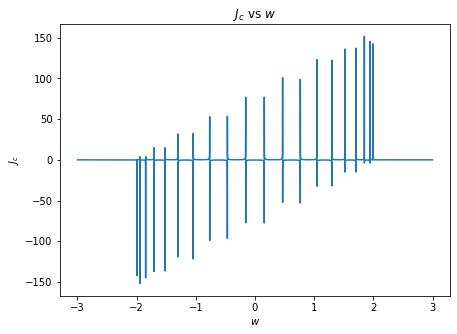

In [15]:
start_time = time()

w1,Den_corr = Jc_w(-3,3,90001)
plt.figure(figsize=(7,5))
plt.plot(w1,Den_corr.real) # grafico la densidad de corriente
plt.title("$J_c$ vs $w$")
plt.xlabel("$w$")
plt.ylabel("$J_c$")
elapsed_time = time() - start_time
print("Elapsed time: %.10f seconds." % elapsed_time)

In [16]:
def Jc_p(p_0,p_f,n_p):
    p1 = np.linspace(p_0,p_f,n_p)
    Jc = np.array([],dtype=complex)
    for p in p1:
        global theta
        theta = 2.0*np.pi*p/N
        A = matrix_A(w,theta,psi)       # creamos la matriz A
        G = spsolve(A,B)
        G = np.asarray(G).ravel()
        Jc = np.append(Jc,den_corr(G,w,theta,psi)) # calculamos densidad espectral
    return p1, Jc

Elapsed time: 331.9171411991 seconds.


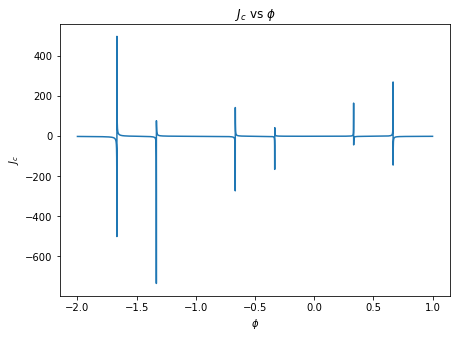

In [17]:

w = 1.0  # introducir w
start_time = time()

p1,Den_corr = Jc_p(-2,1,100001)
plt.figure(figsize=(7,5))
plt.plot(p1,Den_corr.real) # grafico la densidad de corriente
plt.title("$J_c$ vs $\phi$")
plt.xlabel("$\phi$")
plt.ylabel("$J_c$")
elapsed_time = time() - start_time
print("Elapsed time: %.10f seconds." % elapsed_time)